In [1]:
!pip install -q ultralytics supervision gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 9.8 MB/s eta 0:00:00


In [2]:
!pip install pytube openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is inc

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Video processing

In [5]:
from pytube import YouTube
import os

import cv2
import math
import json
import copy
import base64
import requests

import numpy as np
import pandas as pd
import supervision as sv

from tqdm.notebook import tqdm
from ultralytics import YOLO
from typing import List, Optional, Dict, Iterator, Tuple

In [6]:
def single_video_download(path="/content", url='https://www.youtube.com/watch?v=8ZabZYk8tBg'):
      try:
          yt = YouTube(url)

          video = yt.streams.filter(progressive=True, file_extension='mp4', res="720p").first()

          if not video:
              video = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()

          if video:
              video.download(output_path=path)

              print(f"Downloaded {yt.title} at {video.resolution} successfully")


          else:
              print(f"No video available for {url}")

      except Exception as e:
          print(f"Failed to download {url}: {str(e)}")

In [7]:
single_video_download()

Downloaded U23 GetScouted Showcase Match Footage | London | October 29th 2021 - UK Football Trials at 720p successfully


## Helper function

In [25]:
COLOR_HEX_LIST = [
    "#EE4B2B",
    "#FFFF00",
    "#D3D3D3"
]


def annotate_prompt(
    image: np.ndarray,
    detections: sv.Detections,
    labels: Optional[List[str]] = None
) -> np.ndarray:
    """
    Annotates an image with bounding boxes and labels based on provided detections.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in a format compatible with sv.BoundingBoxAnnotator
            and sv.LabelAnnotator, typically a NumPy array.
        detections (sv.Detections): A collection of detections, each typically containing information like
            bounding box coordinates, class IDs, etc., to be used for annotation.
        labels (Optional[List[str]]): A list of strings representing the labels for each detection. If not
            provided, labels are automatically generated as sequential numbers.

    Returns:
        np.ndarray: An annotated version of the input image, with bounding boxes and labels drawn over it.

    """
    bounding_box_annotator = sv.BoundingBoxAnnotator(
        color=sv.Color.black(),
        color_lookup=sv.ColorLookup.CLASS)
    label_annotator = sv.LabelAnnotator(
        color=sv.Color.black(),
        text_color=sv.Color.white(),
        color_lookup=sv.ColorLookup.CLASS,
        text_scale=0.7)

    if labels is None:
        labels = [str(i) for i in range(len(detections))]

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(
        annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections=detections, labels=labels)

    return annotated_image


def annotate_result(
    image: np.ndarray,
    detections: sv.Detections
) -> np.ndarray:
    """
    Annotates a given image with ellipses around detected objects.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in the format
            acceptable by sv.EllipseAnnotator.
        detections (sv.Detections): An object of sv.Detections, which contains
            the detected objects' information to be annotated on the image.

    Returns:
        np.ndarray: An image (numpy array) with ellipses drawn around the detected
            objects. This image is a modified copy of the input image.
    """
    ellipse_annotator = sv.EllipseAnnotator(
        color=sv.ColorPalette.from_hex(color_hex_list=COLOR_HEX_LIST),
        color_lookup=sv.ColorLookup.CLASS,
        thickness=4)

    annotated_image = image.copy()
    annotated_image = ellipse_annotator.annotate(
        annotated_image, detections)
    return annotated_image


In [9]:
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"


def encode_image_to_base64(image: np.ndarray) -> str:
    success, buffer = cv2.imencode('.jpg', image)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image


def compose_payload(images: np.ndarray, prompt: str) -> dict:
    text_content = {
        "type": "text",
        "text": prompt
    }
    image_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image_to_base64(image=image)}"
            }
        }
        for image
        in images
    ]
    return {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "user",
                "content": [text_content] + image_content
            }
        ],
        "max_tokens": 300
    }


def compose_headers(api_key: str) -> dict:
    return {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }


def prompt_image(api_key: str, images: np.ndarray, prompt: str) -> str:
    headers = compose_headers(api_key=api_key)
    payload = compose_payload(images=images, prompt=prompt)
    response = requests.post(url=OPENAI_API_URL, headers=headers, json=payload).json()

    if 'error' in response:
        raise ValueError(response['error']['message'])
    return response['choices'][0]['message']['content']

In [27]:
def chunk_list(lst: List, n: int) -> Iterator[List]:
    """
    Yield successive n-sized chunks from a list.

    Parameters:
        lst (List): The list to be chunked.
        n (int): The size of each chunk.

    Yields:
        Iterator[List]: An iterator over the chunks of the list, each being a list of maximum `n` elements.
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

## Load the model

In [10]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 172MB/s]


## Extract single frame from sample video

In [11]:
VIDEO_PATH = '/content/U23 GetScouted Showcase Match Footage  London  October 29th 2021 - UK Football Trials.mp4'
sv.VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=120812)

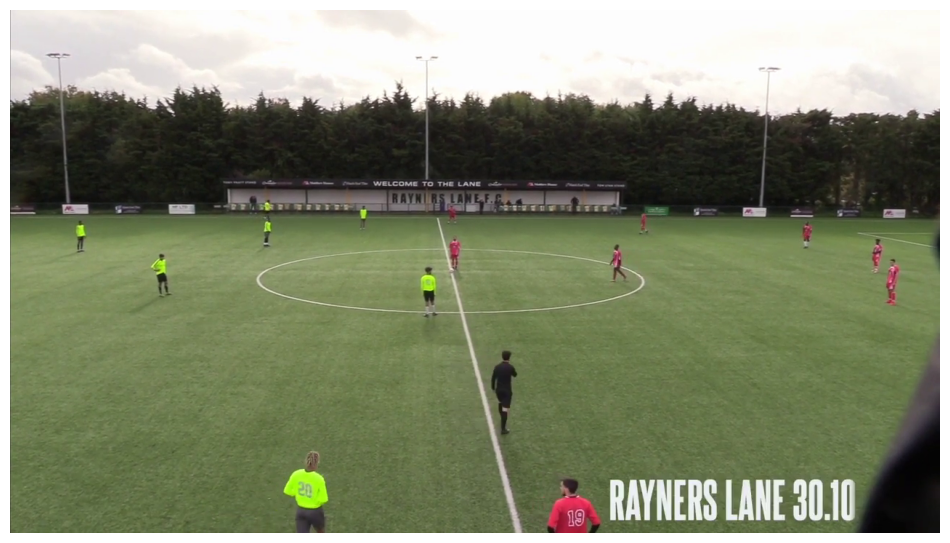

In [16]:
frame_generator = sv.get_video_frames_generator(VIDEO_PATH, start=250)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)
sv.plot_image(frame)

## Baseline object detection with YOLO

<ipython-input-8-7f4890e38509>:29: DeprecationWarning: black is deprecated: `Color.black()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.BLACK` instead.
  color=sv.Color.black(),
<ipython-input-8-7f4890e38509>:32: DeprecationWarning: black is deprecated: `Color.black()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.BLACK` instead.
  color=sv.Color.black(),
<ipython-input-8-7f4890e38509>:33: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  text_color=sv.Color.white(),


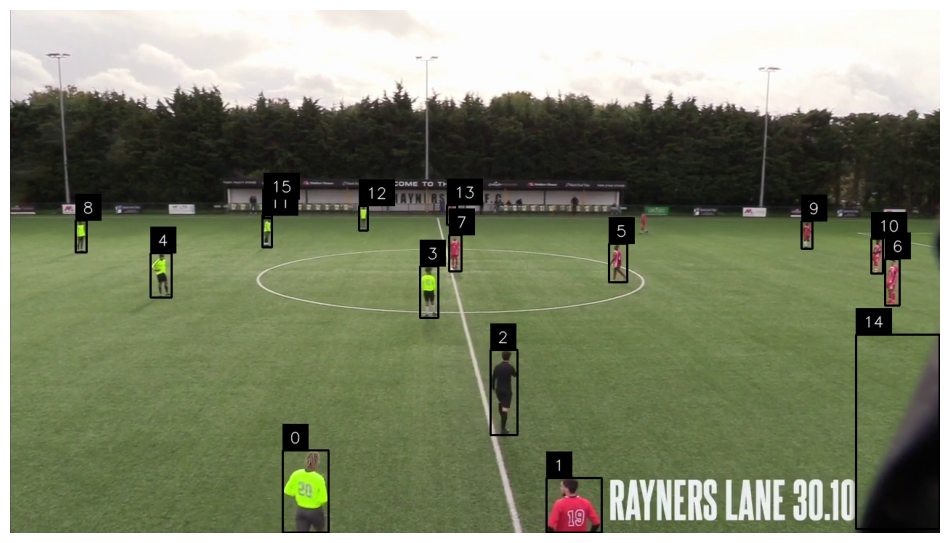

In [17]:
result = model(frame, imgsz=1280, verbose=False, iou=0.5, conf=0.5)[0]

detections = sv.Detections.from_ultralytics(result)

players = detections[detections.class_id == 0]
ball = detections[detections.class_id == 31]

annotated_frame = annotate_prompt(image=frame, detections=players)
sv.plot_image(annotated_frame)


## Prompt GPT-4 Vision

In [1]:
OPENAI_API_KEY = "my_api_key"

In [19]:
prompt = (
    "What colors of uniforms are worn by the teams playing in this match? "
    "Return the result in the form of a python list: [, ]. "
    "Replace the values in `<>` with the names of the colors."
    "notalk;justgo"
)
response = prompt_image(api_key=OPENAI_API_KEY, images=[frame], prompt=prompt)
print(response)

["neon yellow", "red"]


In [21]:
CLASSES = json.loads(response) + ["none"]
print(CLASSES)

['neon yellow', 'red', 'none']


## Team assignment based on whole photo

In [22]:
prompt = (
    "Identify the team affiliation of the marked individual in the image: "
    "Options are `neon yellow` or `red`. If the marked individual does not belong to either team "
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "Coaches and fans should not be considered as team members. "
    "Provide the results in JSON format. The output should include 23 key-value pairs, each representing a bounding box. "
    "Format the output like this: {'0': 'color_1', '1': 'color_2', ...}, "
    "where 'color_1', 'color_2', ..., 'color_23' are to be replaced with 'neon yellow', 'red', or 'none', as applicable. "
    "Use double quotes to enclose property names. "
    "Do not surround the result with backticks (`)"
    "notalk;justgo"
)
annotated_frame = annotate_prompt(image=frame, detections=players)
response = prompt_image(api_key=OPENAI_API_KEY, images=[annotated_frame], prompt=prompt)
print(response)

<ipython-input-8-7f4890e38509>:29: DeprecationWarning: black is deprecated: `Color.black()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.BLACK` instead.
  color=sv.Color.black(),
<ipython-input-8-7f4890e38509>:32: DeprecationWarning: black is deprecated: `Color.black()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.BLACK` instead.
  color=sv.Color.black(),
<ipython-input-8-7f4890e38509>:33: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  text_color=sv.Color.white(),


{
  "0": "neon yellow",
  "1": "red",
  "2": "none",
  "3": "neon yellow",
  "4": "neon yellow",
  "5": "red",
  "6": "red",
  "7": "red",
  "8": "neon yellow",
  "9": "red",
  "10": "red",
  "11": "neon yellow",
  "12": "neon yellow",
  "13": "neon yellow",
  "14": "none",
  "15": "neon yellow"
}


In [23]:
def convert_response_to_array(data: Dict[str, str], count: int, classes: List[str]) -> np.ndarray:
    """
      Convert a dictionary of class names to a numpy array of class IDs.

      Parameters:
          data (Dict[str, str]): A dictionary with keys as string representations of indices and
                                  values as class names.
          count (int): The total number of detections or classes.
          classes (List[str]): A list of class names.

      Returns:
          np.ndarray: An array with the mapped class IDs corresponding to the class names.
    """
    category_to_id = {category: i for i, category in enumerate(classes)}
    mapped_data = {int(k): category_to_id.get(v) for k, v in data.items() if v in category_to_id}
    return np.array([mapped_data.get(i) for i in range(count)], dtype=object)


def update_class_id(data: Dict[str, str], detections: sv.Detections, classes: List[str]) -> sv.Detections:
    """
      Update the class_id attribute of a sv.Detections object with class IDs obtained from a response.

      Parameters:
          data (Dict[str, str]): A dictionary with keys as string representations of indices and
                                values as class names from the response.
          detections (sv.Detections): The detections object to update.
          classes (List[str]): A list of class names.

      Returns:
          sv.Detections: A new sv.Detections object with updated class IDs.
    """
    result = copy.deepcopy(detections)
    result.class_id = convert_response_to_array(data=data, count=len(result), classes=classes)
    return result



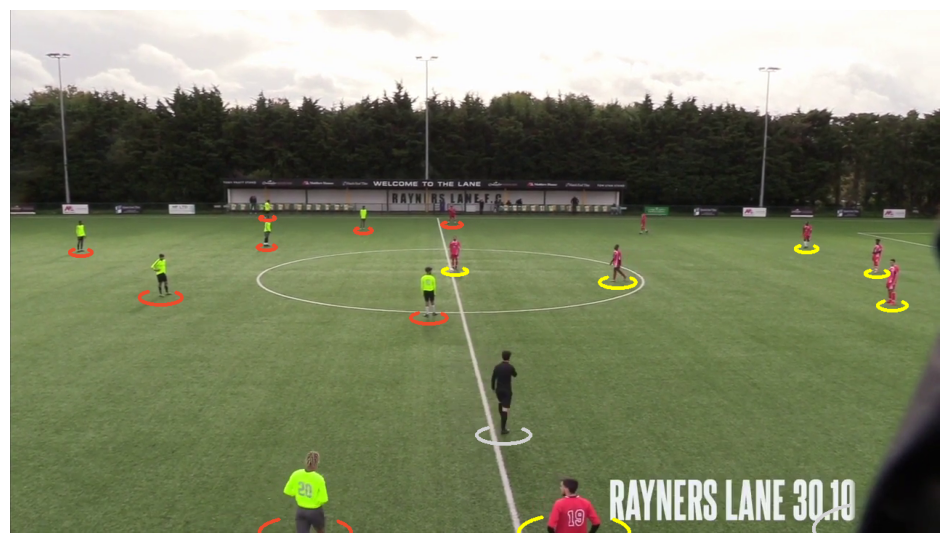

In [26]:
whole_photo_result = update_class_id(data=json.loads(response), detections=players, classes=CLASSES)
result_image = annotate_result(frame, whole_photo_result[whole_photo_result.class_id != None])
sv.plot_image(result_image)

## Team assignment based on crops (one crop per request)

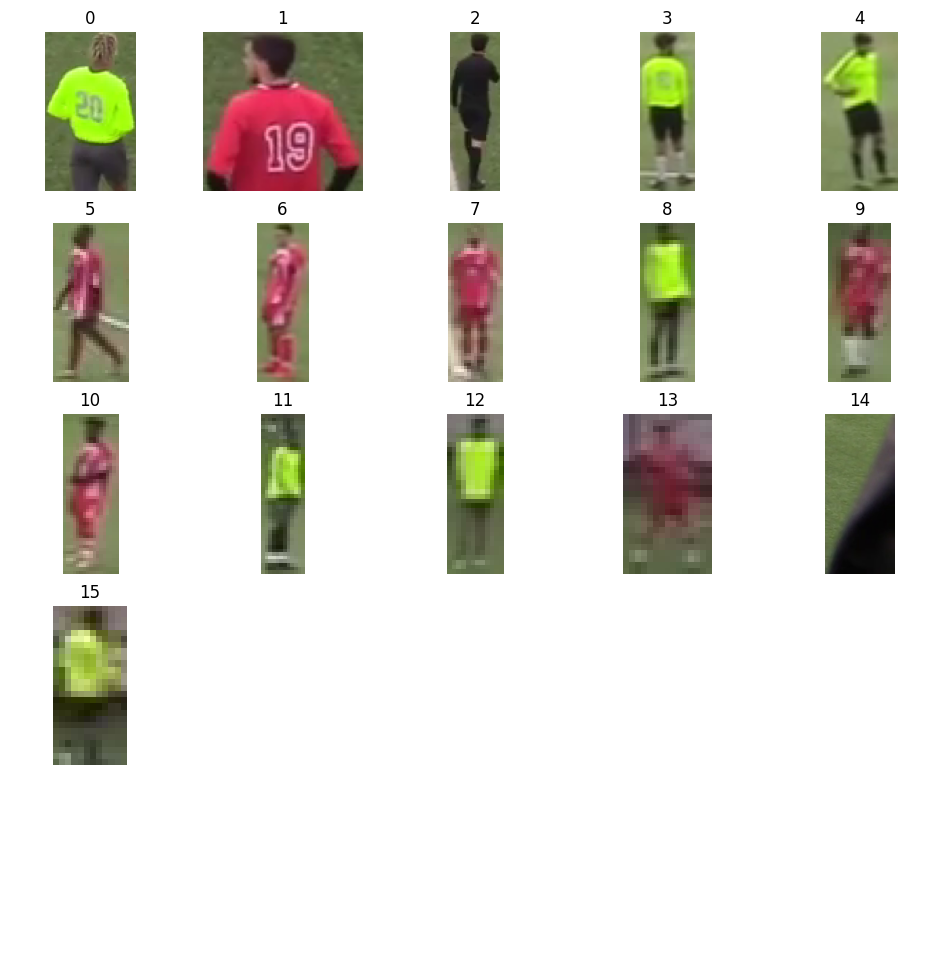

In [28]:
crops = [
    sv.crop_image(frame, players.xyxy[i])
    for i
    in range(len(players))
]

titles = [
    f"{i}"
    for i
    in range(len(players))
]

sv.plot_images_grid(crops, titles=titles, grid_size=(5, 5))

In [44]:
prompt = (
    "Identify the team affiliation of the marked individual in the image: "
    "Options are `neon yellow` or `red`. If the marked individual does not belong to either team "
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "Coaches and fans should not be considered as team members. "
    "Respond only with `neon yellow`, `red`, or `none`. "
    "notalk;justgo"
)

response = {}

for i in tqdm(range(len(players))):
    crop = sv.crop_image(frame, players.xyxy[i])
    try:
        player_response = prompt_image(api_key=OPENAI_API_KEY, images=[crop], prompt=prompt)
        response[str(i)] = player_response
    except Exception as final_exception:
        print(i, final_exception)

  0%|          | 0/16 [00:00<?, ?it/s]

In [45]:
response

{'0': 'neon yellow',
 '1': 'red',
 '2': 'none',
 '3': 'neon yellow',
 '4': 'neon yellow',
 '5': 'red',
 '6': 'red',
 '7': 'red',
 '8': 'neon yellow',
 '9': 'red',
 '10': 'red',
 '11': 'neon yellow',
 '12': 'neon yellow',
 '13': 'none',
 '14': 'none',
 '15': 'none'}

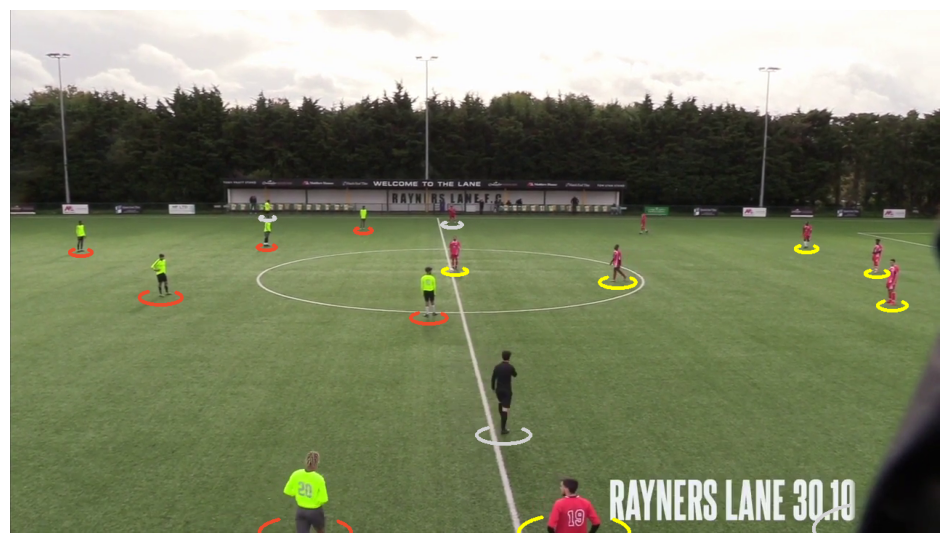

In [46]:
crop_result = update_class_id(data=response, detections=players, classes=CLASSES)
result_image = annotate_result(frame, crop_result[crop_result.class_id != None])
sv.plot_image(result_image)

## Team assignment based on crops (all crops in one request)

In [47]:
xyxy = sv.scale_boxes(players.xyxy, factor=1.2)
crops = [
    sv.crop_image(frame, xyxy[i])
    for i
    in range(len(players))
]

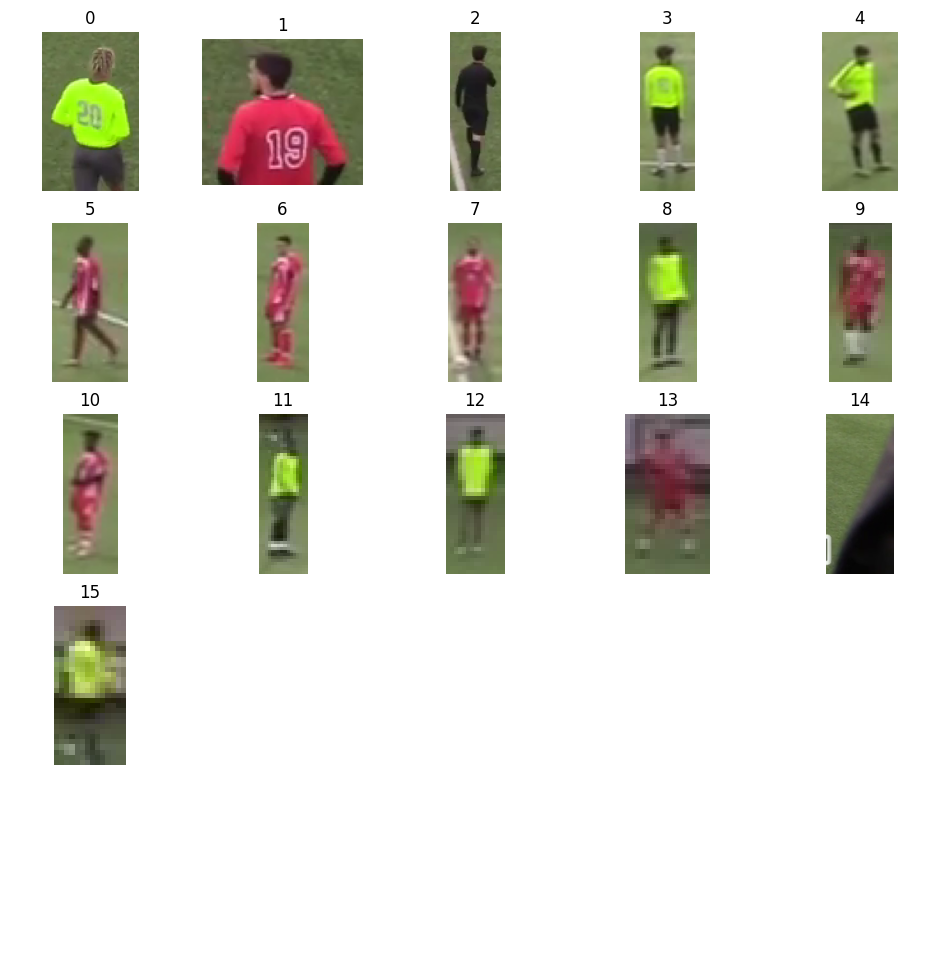

In [48]:
sv.plot_images_grid(crops, titles=titles, grid_size=(5, 5))